In [1]:
import cv2
import numpy as np
import pandas as pd
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dense,Flatten,Dropout,AvgPool2D
from keras.layers.normalization import BatchNormalization
from keras.constraints import unit_norm

In [2]:
labels=pd.read_csv('../input/dog-breed-identification/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
breeds=list(labels['breed'].unique())
len(breeds)

120

In [4]:
## dividing the train data into different folders according to their breed names
os.mkdir('/kaggle/working/new_train')

for i in range(len(labels)):
    if labels['breed'][i] not in os.listdir('/kaggle/working/new_train'):
        os.mkdir('/kaggle/working/new_train/'+labels['breed'][i])
    shutil.copy('../input/dog-breed-identification/train/'+labels['id'][i]+'.jpg', '/kaggle/working/new_train/'+labels['breed'][i])


In [5]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size=224  #for the inception model
image_path='/kaggle/working/new_train/'

train_datagen=ImageDataGenerator(
                        rescale=1./255,
                        validation_split=0.1,
                        horizontal_flip=True,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        rotation_range=40,
                        fill_mode='nearest'
                        )

train_generator=train_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='training',
                        shuffle=True,
                        batch_size=128,
                        class_mode='categorical'
                        )

valid_datagen=ImageDataGenerator(
                        validation_split=0.1,
                        rescale=1./255
                        )

valid_generator=valid_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='validation',
                        shuffle=False,
                        batch_size=128,
                        class_mode='categorical'
                        )

Found 9254 images belonging to 120 classes.
Found 968 images belonging to 120 classes.


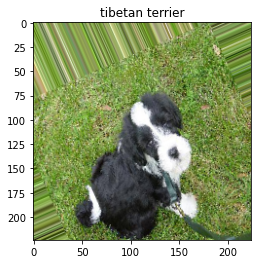

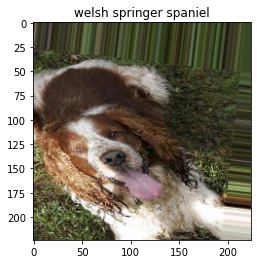

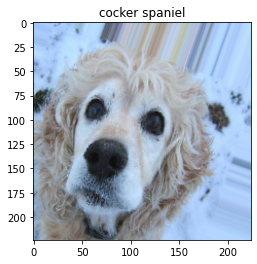

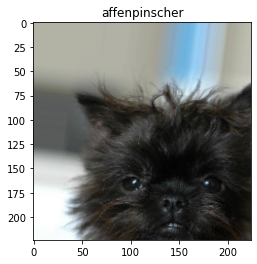

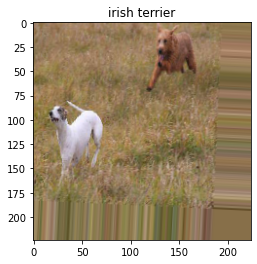

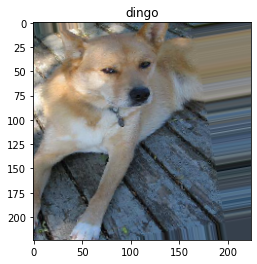

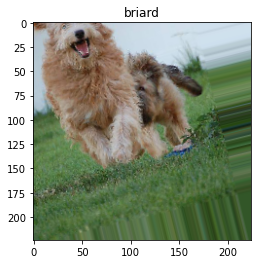

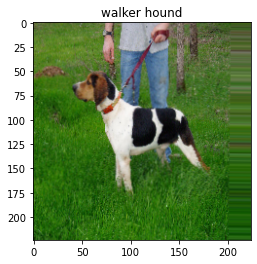

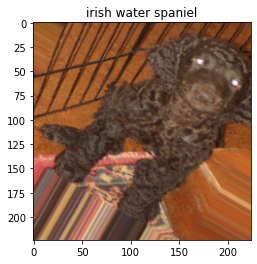

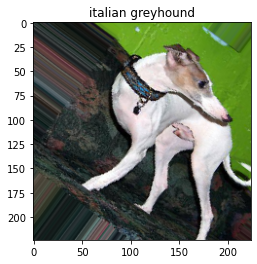

In [6]:
x,y = train_generator.next()
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
for i in range(0,10):
    image = x[i]
    plt.imshow(image)
    c=0
    for i in y[i]:
        if i==0:
            c+=1
        else:break
    label=labels[c]
    label=label.replace('_',' ')
    label=label.lower()
    plt.title(label)
    plt.show()

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

#using pre-trained weights for the inception model
local_weights_file = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
Inception = InceptionV3(input_shape = (224,224,3), 
                                include_top = False, 
                                weights = local_weights_file)

#building a sequential model with inception layer base and only an average pooling layer before the output layer

model2=Sequential()
model2.add(Inception)

model2.add(GlobalAveragePooling2D())
model2.add(Dense(512,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(len(breeds),activation='softmax'))

model2.layers[0].trainable=False

model2.compile(optimizer='sgd',
             loss='categorical_crossentropy',
             metrics=['accuracy']
             )

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 22,913,432
Trainable params: 1,110,648
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
callback=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,min_delta=0,mode='auto',restore_best_weights=False,baseline=None)

history=model2.fit_generator(train_generator,
                   steps_per_epoch=73,
                   epochs=100,
                   validation_data=valid_generator,
                   validation_steps=8,
                   callbacks=[callback])

Epoch 1/100
73/73 [==============================] - 136s 2s/step - loss: 4.5545 - accuracy: 0.0759 - val_loss: 3.7717 - val_accuracy: 0.2893
Epoch 2/100
73/73 [==============================] - 134s 2s/step - loss: 3.5591 - accuracy: 0.2913 - val_loss: 2.6839 - val_accuracy: 0.5702
Epoch 3/100
73/73 [==============================] - 134s 2s/step - loss: 2.7459 - accuracy: 0.4553 - val_loss: 1.8570 - val_accuracy: 0.6963
Epoch 4/100
73/73 [==============================] - 134s 2s/step - loss: 2.1895 - accuracy: 0.5360 - val_loss: 1.3815 - val_accuracy: 0.7366
Epoch 5/100
73/73 [==============================] - 134s 2s/step - loss: 1.8763 - accuracy: 0.5688 - val_loss: 1.1249 - val_accuracy: 0.7593
Epoch 6/100
73/73 [==============================] - 134s 2s/step - loss: 1.6523 - accuracy: 0.6013 - val_loss: 0.9854 - val_accuracy: 0.7748
Epoch 7/100
73/73 [==============================] - 134s 2s/step - loss: 1.5306 - accuracy: 0.6154 - val_loss: 0.9015 - val_accuracy: 0.7893
Epoch 

In [9]:
os.mkdir('/kaggle/working/models/')
model2.save('/kaggle/working/models/my_dog_model.h5')

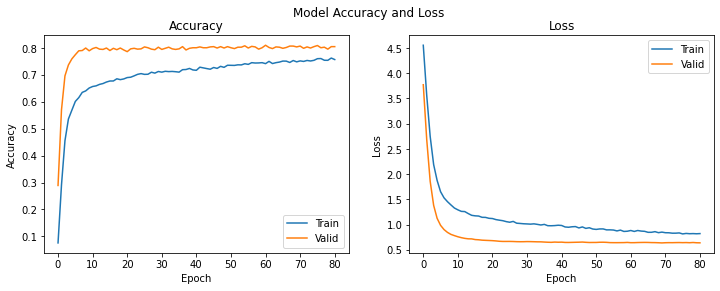

In [10]:
def plot_model(history):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    fig.suptitle('Model Accuracy and Loss')

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train','Valid'],loc=4)

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train','Valid'],loc=1)

    fig.show()

plot_model(history)

In [11]:
os.mkdir('/kaggle/working/new_test')
os.mkdir('/kaggle/working/new_test/test')
test_images=os.listdir('../input/dog-breed-identification/test/')

for i in range(len(test_images)):
    shutil.copy('../input/dog-breed-identification/test/'+test_images[i],'/kaggle/working/new_test/test')

In [12]:
test_generator = valid_datagen.flow_from_directory(
    '/kaggle/working/new_test/',
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 10357 images belonging to 1 classes.


In [13]:
test_generator.reset()
pred=model2.predict_generator(test_generator,verbose=1,steps=10357/32)

324/323 [==============================] - 42s 130ms/step


In [14]:
n = len(labels)
n_class = len(breeds)  
class_to_num = dict(zip(breeds, range(n_class)))
num_to_class = dict(zip(range(n_class), breeds))

df2 = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

for b in breeds:
    df2[b] = pred[:,class_to_num[b]]

df2.to_csv('pred.csv', index=None)

In [15]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [16]:
from cv2 import imread
from keras.applications.inception_v3 import preprocess_input

def predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((image_size,image_size))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model2.predict(np.expand_dims(img, axis=0))
    
    dict1={}
    for i,j in enumerate(probs[0]):
        dict1[i]=j
    
    a=max(dict1.keys(), key=(lambda k: dict1[k]))
    predicted_breed=breeds[a]
    print(predicted_breed)

In [ ]:
#predict("https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12224329/Shih-Tzu-On-White-01.jpg","test_image_1.jpg")